# Package loading and basic configurations

In [1]:
%load_ext autoreload
%autoreload 2

# load dependencies'
import matplotlib.pyplot as plt
import scipy
import math  
from scipy.misc import derivative
from scipy import interpolate
import datetime
import numpy as np
import pandas as pd
import geopandas as gpd
from envirocar import TrackAPI, DownloadClient, BboxSelector, TimeSelector, ECConfig

# create an initial but optional config and an api client
config = ECConfig()
track_api = TrackAPI(api_client=DownloadClient(config=config))

# Querying enviroCar Tracks

The following cell queries tracks from the enviroCar API. It defines a bbox for the area of Münster (Germany) and requests 50 tracks in the time interval. 

In [2]:
bbox = BboxSelector([
    7.603312, # min_x
    51.952343, # min_y
    7.65083, # max_x 
    51.974045,  # max_y 
])


# issue a query
track_df = track_api.get_tracks(bbox=bbox,  num_results=50) # requesting 50 tracks inside the bbox


In [3]:
track_df

,id,time,geometry,Speed.value,Speed.unit,Throttle Position.value,Throttle Position.unit,GPS VDOP.value,GPS VDOP.unit,GPS Altitude.value,...,sensor.constructionYear,sensor.manufacturer,track.appVersion,track.touVersion,O2 Lambda Voltage ER.value,O2 Lambda Voltage ER.unit,MAF.value,MAF.unit,O2 Lambda Voltage.value,O2 Lambda Voltage.unit
0,5eec7aa7d6e3cf256ba3effb,2020-06-18T21:49:51,POINT (7.65252 51.95404),0.000000,km/h,17.000000,%,1.000000,precision,100.000003,...,2007,Dodge,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5eec7aa7d6e3cf256ba3effd,2020-06-18T21:49:56,POINT (7.65252 51.95404),0.000000,km/h,17.000000,%,0.868047,precision,100.000003,...,2007,Dodge,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5eec7aa7d6e3cf256ba3effe,2020-06-18T21:50:01,POINT (7.65252 51.95404),0.000000,km/h,16.000000,%,1.000000,precision,99.999997,...,2007,Dodge,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5eec7aa7d6e3cf256ba3efff,2020-06-18T21:50:06,POINT (7.65252 51.95404),0.000000,km/h,17.000000,%,0.872764,precision,100.000000,...,2007,Dodge,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5eec7aa7d6e3cf256ba3f000,2020-06-18T21:50:11,POINT (7.65249 51.95402),2.000000,km/h,16.000000,%,1.000000,precision,98.000003,...,2007,Dodge,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,5dc9879b44ea856b702e87b3,2019-10-25T15:27:30,POINT (7.59691 51.96494),48.000000,km/h,15.000000,%,1.234059,precision,107.027202,...,2004,Mercedes Benz,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
96,5dc9879b44ea856b702e87b4,2019-10-25T15:27:35,POINT (7.59596 51.96498),47.000000,km/h,15.645408,%,1.270751,precision,107.465144,...,2004,Mercedes Benz,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
97,5dc9879b44ea856b702e87b5,2019-10-25T15:27:40,POINT (7.59503 51.96504),45.000001,km/h,14.000000,%,1.200000,precision,107.772621,...,2004,Mercedes Benz,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
98,5dc9879b44ea856b702e87b6,2019-10-25T15:27:45,POINT (7.59412 51.96510),47.000000,km/h,15.010840,%,1.200000,precision,108.350235,...,2004,Mercedes Benz,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Define car parameters

In [4]:
#Define General Parameters

P_air = 1.2   # Air mass density "kg per m³" 
P_idle = 2    # Idle power "kW"
Cw = 0.3      # Air drag cofficient 
H_g = 8.8     # Calorific value gasoline "kWh/l"
H_d = 9.9     # Calorific value diesel "kWh/l"
g = 9.81      # Gravitational acceleration "m/s²"
efc = 0.30    # efficiency constant value from Literature 0.25 - 0.35

#Define Car parameters
class Car:
    def __init__(self,m=1500,A=2,Cw=0.3):
        self.m = m
        self.A = A
        self.Cw = Cw

##  Define specific paramerer by class (Volkswagen)
volks = Car(1570,2.179,0.32)
##generalcar = car
car = Car()


In [7]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

## Different functions (distance, gradient, speed equation, fuel consumption, engine power)

In [5]:
def distance(lon1,lon2,lat1,lat2): 
    b = 69.1 * (lat2 - lat1)
    e = 69.1 * (lon2 - lon1) * np.cos(lat1/57.3)
    d = math.sqrt((b ** 2) + (e ** 2)) * 1609.344
    return d

def gradient(height,distance):
    return height/distance

#Get speed equation
def get_equation(x,y):
    degree = 80
    coefs, res, _, _, _ = np.polyfit(x,y,degree, full = True)
    ffit = np.poly1d(coefs)
    #print (ffit)
    return ffit

def fuel_consumption(eng_pow, H_fuel, efc):
    consumption = eng_pow / (H_fuel * efc)
    return consumption

## Define engine power (KW)
def engine_power(car,Cr,gradient,speed,acceleration):
    if speed > 0:
        power =speed*(0.5*car.Cw*car.A*P_air*pow(speed,2) #driving resistance
                      +car.m*g*Cr*np.cos(gradient) #rolling resistence
                      +car.m*g*np.sin(gradient) # climbing resistance
                      +car.m*+acceleration) # inertial resistance
        return [power/1000, power/speed]
    else:
        resistance =(0.5*car.Cw*car.A*P_air*pow(speed,2) #driving resistance
                      +car.m*g*Cr*np.cos(gradient) #rolling resistence
                      +car.m*g*np.sin(gradient) # climbing resistance
                      +car.m*+acceleration) # inertial resistance
        return [P_idle, resistance]

def interpolation(x):
    A = [-2000, 2000]
    B = [0.1, 0.4]
    f = interpolate.interp1d(A, B)
    efficiency = f(x)
    return efficiency
    
import time
import requests as req,json
url = 'https://api.opentopodata.org/v1/eudem25m?locations='
def generate_parms(s,e):
    lats= list(one_track[s:e]['geometry'].y)
    lngs = list(one_track[s:e]['geometry'].x)
    track_coords = [c for c in zip(lats, lngs)]
    format_str=list(map(lambda x : str(x[0])+','+str(x[1])+'|', track_coords)) 
    concat_str = ''.join(format_str)
    return concat_str

def request(link):
    elevation = req.request('GET',link)
    results = elevation.json()['results']
    h = list(map(lambda x : x['elevation'], results))
    return h

## Estimate fuel consumption/Co2 emissions for all tracks

In [6]:
tracks = pd.DataFrame(columns=track_df.columns)
for i in range (10,30):
    one_track_id = track_df['track.id'].unique()[i]
    one_track = track_df[track_df['track.id'] == one_track_id]
    # estimate the len of data
    batch = [int(len(one_track)/100),len(one_track)%100]
    elevation=[]
    # get elevation 
    for i in range(batch[0]+1):
        #create requeest 100 parameter 
        s = i*100
        e = (i+1)*100
        if i<batch[0]+1:
            --e 
        else:
            e= e+batch[1]

        parms= generate_parms(s,e)
        access= url+parms
        part = request(access)
        elevation.extend(part)
        time.sleep(1)
    one_track['elevation']=elevation
    
    
    for i in one_track.index:
        if (i == len(one_track)-1):
            break
        lat1= one_track.loc[i,'geometry'].y
        lat2= one_track.loc[i+1,'geometry'].y
        lon1= one_track.loc[i,'geometry'].x
        lon2= one_track.loc[i+1,'geometry'].x
        heightdiff = one_track.loc[i+1,'elevation'] - one_track.loc[i,'elevation']
        one_track.loc[i+1,'seg_distance']= distance(lon1,lon2,lat1,lat2)
        grade = gradient(heightdiff,one_track.loc[i+1,'seg_distance'])
        one_track.loc[i,'gradient']= grade
    ## Add interval time
    j = 5
    for i in one_track.index:
        one_track.loc[i, 'time_interval'] = j
        j = j+5
    # Convert the speed unit to m/s
    for i in one_track.index:
        one_track.loc[i, 'speed'] = one_track.loc[i, 'GPS Speed.value'] / 3.6
        
    time_interval = np.array(one_track['time_interval'])
    for i in one_track.index:
        if (i == len(one_track)-1):
            break
        else:
            one_track.loc[i, 'Acceleration'] = (one_track.loc[i+1, 'speed'] - one_track.loc[i, 'speed'])/5
    ## Calculates Engine Power for general car
    for i in one_track.index:
        ep = engine_power(car,0.02,one_track.gradient[i],one_track.speed[i],one_track.Acceleration[i])
        if ep[0] < 0:
            one_track.loc[i, 'engine_power'] = P_idle
            one_track.loc[i, 'driving_resistance'] = ep[1]
        else:
            one_track.loc[i, 'engine_power'] = ep[0]
            one_track.loc[i, 'driving_resistance'] = ep[1]
    #Calculates Engine Power for Volks
    for i in one_track.index:
        ep = engine_power(volks,0.02,one_track.gradient[i],one_track.speed[i],one_track.Acceleration[i])
        if ep[0] < 0:
            one_track.loc[i, 'eng_pw_volks'] = P_idle
            one_track.loc[i, 'driving_resistance'] = ep[1]
        else:
            one_track.loc[i, 'eng_pw_volks'] = ep[0]
            one_track.loc[i, 'driving_resistance_volks'] = ep[1]
            
    for i in one_track.index:
        res = one_track.loc[i, 'driving_resistance']
        res_volks = one_track.loc[i, 'driving_resistance_volks']
        if (res >= 2000 or res <= -2000):
            one_track.loc[i,'efficiency'] = 0.3
        else:
            one_track.loc[i, 'efficiency'] = interpolation(res)
        if (res_volks >= 2000 or res_volks <= -2000):
            one_track.loc[i,'efficiency_volks'] = 0.3
        else:
            one_track.loc[i, 'efficiency_volks'] = interpolation(res_volks)            
            
    ## Fuel consumption/CO2 emissions for General car (gasoline)
    for i in one_track.index:
        car_cons = fuel_consumption(one_track.engine_power[i],H_g, one_track.loc[i,'efficiency']) 
        one_track.loc[i, 'Consumption_Gasoline'] = car_cons   ## liters / hour
        one_track.loc[i, 'CO2_Gasoline'] = car_cons * 2.39      ## kg Co2 / hour

    
    ## Fuel consumption/CO2 emissions for for Volks (diesel)
    for i in one_track.index:
        volks_cons = fuel_consumption(one_track.eng_pw_volks[i],H_d, one_track.loc[i, 'efficiency_volks']) 
        one_track.loc[i, 'Consumption_volks_diesel'] = volks_cons    ## liters / hour
        one_track.loc[i, 'CO2_volks_diesel'] = volks_cons * 2.69     ## kg Co2 / hour
    
    tracks = pd.concat([tracks, one_track])

C:\Users\a\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\a\Anaconda3\lib\site-packages\pandas\core\indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\a\Anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

## Filter the data

In [8]:
## filter attributes for all tracks 
all_tracks = tracks[['time', 'speed', 'time_interval', 'Acceleration', 'gradient', 'engine_power', 'eng_pw_volks', 'Consumption.value', 'Consumption_Gasoline','CO2_Gasoline','Consumption_volks_diesel','CO2_volks_diesel','geometry' ]]

## filter attributes for one track
one_track_id = tracks['track.id'].unique()[11]
track = tracks[tracks['track.id'] == one_track_id]

one_track = track[['time', 'speed', 'time_interval', 'Acceleration', 'elevation','gradient', 'engine_power','driving_resistance','efficiency', 'eng_pw_volks', 'Consumption.value','Consumption_Gasoline','CO2_Gasoline','Consumption_volks_diesel','CO2_volks_diesel']]
one_track

,time,speed,time_interval,Acceleration,elevation,gradient,engine_power,driving_resistance,efficiency,eng_pw_volks,Consumption.value,Consumption_Gasoline,CO2_Gasoline,Consumption_volks_diesel,CO2_volks_diesel
0,2019-12-29T12:11:19,3.802064,5.0,0.148187,-0.312093,0.006931,2.371581,623.761473,0.296782,2.484539,2.201733,0.908066,2.170278,0.839314,2.257755
1,2019-12-29T12:11:25,4.543000,10.0,-0.180077,-0.209130,0.001434,0.239459,52.709425,0.253953,0.254531,3.186081,0.107151,0.256090,0.101141,0.272069
2,2019-12-29T12:11:30,3.642615,15.0,-0.702525,-0.176606,0.010470,2.000000,-628.149130,0.202889,2.000000,1.890531,1.120184,2.677239,NaN,NaN
3,2019-12-29T12:11:35,0.129990,20.0,-0.025998,-0.065007,-0.012105,0.010032,77.172731,0.255788,0.010500,1.771329,0.004457,0.010651,0.004142,0.011142
4,2019-12-29T12:11:40,0.000000,25.0,0.000000,-0.066134,-0.020266,2.000000,-3.949228,0.249704,2.000000,1.833710,0.910169,2.175305,0.809084,2.176436
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1722,2019-12-29T14:36:43,0.000000,8615.0,0.047910,62.675255,0.000137,2.000000,368.178855,0.277613,2.000000,1.685962,0.818666,1.956612,0.724341,1.948477
1723,2019-12-29T14:36:48,0.239552,8620.0,-0.047910,62.675323,-0.007448,0.027033,112.848897,0.258464,0.028295,2.153064,0.011885,0.028406,0.011041,0.029701
1724,2019-12-29T14:36:53,0.000000,8625.0,0.000000,62.666435,-0.000309,2.000000,289.754600,0.271732,2.000000,1.690632,0.836387,1.998965,0.740691,1.992458
1725,2019-12-29T14:36:58,0.000000,8630.0,0.000000,62.666382,0.003368,2.000000,343.854834,0.275789,2.000000,1.793028,0.824082,1.969555,0.729334,1.961909


## Comprasion between estimated fuel consumption & ODM values for one route

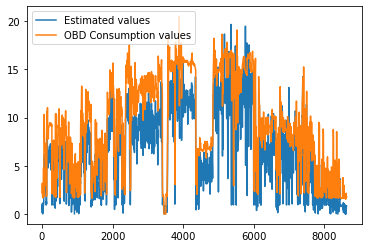

In [9]:
f, axarr = plt.subplots(1)
x = time_interval = np.array(one_track['time_interval'])
y1 = np.array(one_track['Consumption_Gasoline'])
y2 = np.array(one_track['Consumption.value'])
one = axarr.plot(x,y1, label="Estimated values")
two = axarr.plot(x,y2, label="OBD Consumption values" )
axarr.legend()
plt.show()

### The relationship between consumption and speed/acceleration

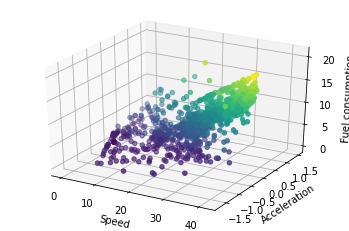

In [10]:

#set axes
ax = plt.axes(projection='3d')
zdata = np.array(one_track['Consumption.value'])
xdata = np.array(one_track['speed']) 
ydata = np.array(one_track['Acceleration'])

#set labels
ax.set_xlabel('Speed')
ax.set_ylabel('Acceleration')
ax.set_zlabel('Fuel consumption')

ax.scatter3D(xdata, ydata, zdata, c=zdata);


## Plot different variables for one track

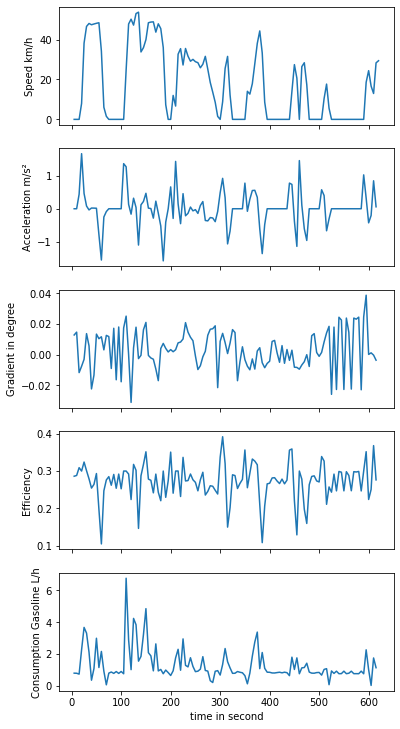

In [11]:
## select on track
one_track_id = tracks['track.id'].unique()[5]
track = tracks[tracks['track.id'] == one_track_id]

one_track = track[['time', 'speed', 'time_interval', 'Acceleration', 'elevation','gradient', 'engine_power','driving_resistance','efficiency', 'eng_pw_volks', 'Consumption.value','Consumption_Gasoline','CO2_Gasoline','Consumption_volks_diesel','CO2_volks_diesel']]
one_track

f, axarr = plt.subplots(5, sharex=True)
figsize=(8, 6)
time_interval = np.array(one_track['time_interval'])
speed = np.array(one_track['speed']) / 0.27777
acceleration = np.array(one_track['Acceleration'])
Consumption_Gasoline = np.array(one_track['Consumption_Gasoline'])
gradient = np.array(one_track['gradient'])
efficiency = np.array(one_track['efficiency']) 



axarr[0].plot(time_interval , speed)
axarr[1].plot(time_interval , acceleration)
axarr[2].plot(time_interval , gradient)
axarr[3].plot(time_interval , efficiency)
axarr[4].plot(time_interval , Consumption_Gasoline)



axarr[4].set_xlabel('time in second')
axarr[0].set_ylabel('Speed km/h')
axarr[1].set_ylabel('Acceleration m/s²')
axarr[2].set_ylabel('Gradient in degree')
axarr[3].set_ylabel('Efficiency')
axarr[4].set_ylabel('Consumption Gasoline L/h')


plt.subplots_adjust(top=2.5)


## The most efficient driving behaviour on a route

In [34]:
one_track_id = tracks['track.id'].unique()[7]
track = tracks[tracks['track.id'] == one_track_id]
test_track = track[['time','time_interval', 'speed', 'Acceleration', 'elevation','gradient',]]


### Driving behaviour on the route in the city 

In [35]:
# constant speed value

speed = [10, 20, 30, 40, 50]
acceleration = [0]
columns = ['consumption_10', 'consumption_20', 'consumption_30', 'consumption_40', 'consumption_50']
accumulate_consumption = ['accumulate_10', 'accumulate_20', 'accumulate_30', 'accumulate_40', 'accumulate_50']
cumulated = 0
cumulated_fuel = []
for x in range(0,5):
    test_track.insert(2,columns[x], True)
    for i in test_track.index:
        ep = engine_power(car,0.02,test_track.gradient[i],speed[x],acceleration[0])
        if ep[0] < 0:
            test_track.loc[i, 'engine_power'] = P_idle
            test_track.loc[i, 'driving_resistance'] = ep[1]
        else:
            test_track.loc[i, 'engine_power'] = ep[0]
            test_track.loc[i, 'driving_resistance'] = ep[1]
    for i in test_track.index:
        res = test_track.loc[i, 'driving_resistance']
        if (res >= 2000 or res <= -2000):
            test_track.loc[i,'efficiency'] = 0.3
            
        else:
            test_track.loc[i, 'efficiency'] = interpolation(res)
                   
    ## Instantaneous/Cumulated Fuel consumption
    for i in test_track.index:
        car_cons = fuel_consumption(test_track.engine_power[i],H_g, test_track.loc[i,'efficiency']) 
        test_track.loc[i, columns[x]] = car_cons
        value = test_track.loc[i, columns[x]]
        if value >=0:
            cumulated += value
        test_track.loc[i, accumulate_consumption[x]] = cumulated
    ## Cumulated Fuel Consumption
    cumulated_fuel.append(cumulated)
    cumulated = 0


In [36]:
test_track

,time,time_interval,consumption_50,consumption_40,consumption_30,consumption_20,consumption_10,speed,Acceleration,elevation,gradient,engine_power,driving_resistance,efficiency,accumulate_10,accumulate_20,accumulate_30,accumulate_40,accumulate_50
0,2020-01-05T15:52:01,5.0,21.1288,13.609,8.01166,4.17906,1.7142,6.121902,0.059594,60.231903,0.006452,64.461693,1289.233868,0.346693,1.714200,4.179056,8.011660,13.608958,21.128786
1,2020-01-05T15:52:06,10.0,20.7989,13.3037,7.75318,3.99026,1.61428,6.419874,-0.154965,60.448933,0.004566,63.074538,1261.490759,0.344612,3.328478,8.169315,15.764841,26.912625,41.927728
2,2020-01-05T15:52:11,15.0,20.68,13.1935,7.65988,3.92208,1.57818,5.645050,-0.038176,60.586002,0.003892,62.578492,1251.569835,0.343868,4.906663,12.091396,23.424722,40.106155,62.607750
3,2020-01-05T15:52:16,20.0,20.7866,13.2922,7.74347,3.98316,1.61052,5.454171,-0.085098,60.652843,0.004496,63.022784,1260.455681,0.344534,6.517184,16.074558,31.168190,53.398355,83.394309
4,2020-01-05T15:52:21,25.0,20.7736,13.2802,7.73334,3.97576,1.6066,5.028682,-1.005736,60.794601,0.004423,62.968825,1259.376500,0.344453,8.123786,20.050317,38.901527,66.678594,104.167951
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,2020-01-05T15:59:41,460.0,22.1436,14.5465,8.80414,4.75714,2.0199,0.000000,0.043027,58.911308,0.012399,68.836554,1376.731078,0.353255,117.201380,305.246983,622.001209,1104.066507,1765.189492
92,2020-01-05T15:59:46,465.0,22.2361,14.6318,8.87616,4.80962,2.04763,0.215135,-0.043027,58.920212,0.012953,69.243547,1384.870938,0.353865,119.249010,310.056603,630.877367,1118.698327,1787.425592
93,2020-01-05T15:59:51,470.0,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,58.947453,NaN,NaN,NaN,NaN,119.249010,310.056603,630.877367,1118.698327,1787.425592
94,2020-01-05T15:59:56,475.0,19.6719,12.2584,6.86659,3.34175,1.27074,0.000000,0.000000,58.947453,-0.001709,58.457743,1169.154866,0.337687,120.519746,313.398358,637.743957,1130.956710,1807.097457


# Fuel consumption based on different time frame

## Plot Instantaneous Fuel consumption at different speed profile

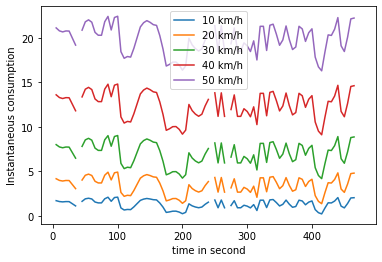

In [26]:
f, axarr = plt.subplots(1)

x = np.array(test_track['time_interval'])
consumption_10 = np.array(test_track['consumption_10']) 
consumption_20 = np.array(test_track['consumption_20'])
consumption_30 = np.array(test_track['consumption_30'])
consumption_40 = np.array(test_track['consumption_40'])
consumption_50 = np.array(test_track['consumption_50']) 

one = axarr.plot(x,consumption_10, label="10 km/h")
two = axarr.plot(x,consumption_20, label="20 km/h" )
three = axarr.plot(x,consumption_30, label="30 km/h")
four = axarr.plot(x,consumption_40, label="40 km/h")
five = axarr.plot(x,consumption_50, label="50 km/h")
axarr.set_xlabel('time in second')
axarr.set_ylabel('Instantaneous consumption')
axarr.legend()
plt.show()

## Plot cumulated Fuel consumption against speed profile

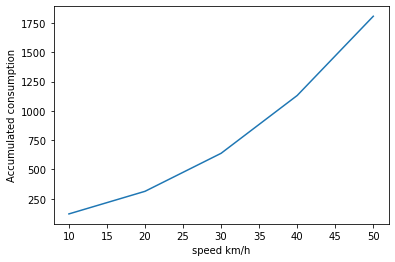

In [27]:
f, axarr = plt.subplots(1)
x = np.array(speed)
y = np.array(cumulated_fuel) 
one = axarr.plot(x,y, label="Accumulated Fuel consumption")
axarr.set_xlabel('speed km/h')
axarr.set_ylabel('Accumulated consumption')
plt.show()

## Plot accumulate Fuel consumption on a route against specific time

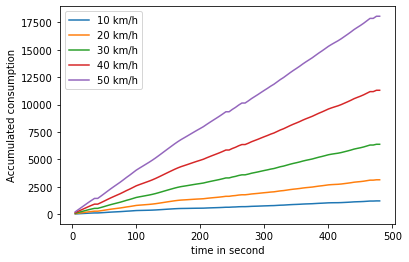

In [38]:
f, axarr = plt.subplots(1)

x = np.array(test_track['time_interval'])
consumption_10 = np.array(test_track['accumulate_10'])
consumption_20 = np.array(test_track['accumulate_20'])
consumption_30 = np.array(test_track['accumulate_30'])
consumption_40 = np.array(test_track['accumulate_40'])
consumption_50 = np.array(test_track['accumulate_50'])

one = axarr.plot(x,consumption_10, label="10 km/h")
two = axarr.plot(x,consumption_20, label="20 km/h" )
three = axarr.plot(x,consumption_30, label="30 km/h")
four = axarr.plot(x,consumption_40, label="40 km/h")
five = axarr.plot(x,consumption_50, label="50 km/h")
axarr.set_xlabel('time in second')
axarr.set_ylabel('Accumulated consumption')
axarr.legend()
plt.show()

## The most efficient route

In [ ]:
import plotly.express as px
tracks['lat'] = tracks['geometry'].apply(lambda coord: coord.y)
tracks['lng'] = tracks['geometry'].apply(lambda coord: coord.x)
tracks.dropna()
#print (tracks)
some_track_flat = tracks[tracks['track.id'] == one_track_id]
#print(some_track_flat)
fig = px.scatter_mapbox(tracks, lat="lat", lon="lng", color="Consumption_Gasoline")
fig.update_layout(mapbox_style="open-street-map")
fig.show()

## The fastest/shortest route


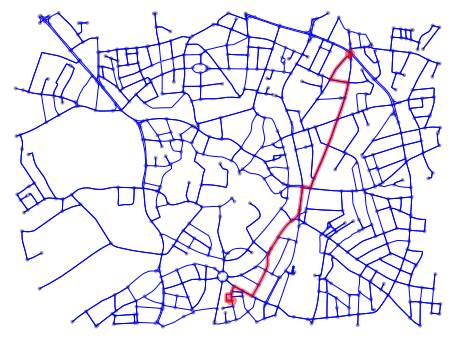

In [190]:
import osmnx as ox
import networkx as nx

G = ox.graph_from_bbox(51.974045, 51.952343, 7.65083, 7.603312, network_type='drive')
orig = list(G)[1]
dest = list(G)[-1]

hwy_speeds = {'residential': 35,
              'secondary': 50,
              'tertiary': 60}
G = ox.add_edge_speeds(G, hwy_speeds)
G = ox.add_edge_travel_times(G)

route1 = nx.shortest_path(G, orig, dest, weight='time')
route = nx.shortest_path(G, orig, dest, weight='length')
fig, ax = ox.plot_graph_route(G, route1, edge_color= 'blue')

## Plot graph on OSM

In [191]:
nodes, streets = ox.graph_to_gdfs(G)

ox.plot_graph_folium(G, graph_map=None, popup_attribute=None, tiles='cartodbpositron', zoom=1, fit_bounds=True, edge_color='#333333', edge_width=1, edge_opacity=1)
streets1 = streets
allstreets = pd.DataFrame(columns=streets.columns)
l = [0] * len(streets)
for i in range (0,20):
    one_track_id = tracks['track.id'].unique()[i]
    one_track = tracks[tracks['track.id'] == one_track_id]
    for i in one_track.index:
        
        lat= one_track.loc[i,'geometry'].y
        lng= one_track.loc[i,'geometry'].x
        u1,v1,key = (ox.get_nearest_edge(G, (lat, lng)))
        index = streets1[(streets1.u ==u1) & (streets1.v ==v1)].index
        num = index.array[0]
        value = one_track.loc[i,'CO2_Gasoline']
        if value>= 0:
            l[num]+= value
     

In [197]:
streets1['co2']=l
l[50]

1622.5782636965505

In [211]:
graph2 = ox.graph_from_gdfs(nodes, streets1)
edge_colors = ox.plot.get_edge_colors_by_attr(graph2, 'co2', num_bins=5, cmap='viridis', start=0, stop=1, na_color='none')

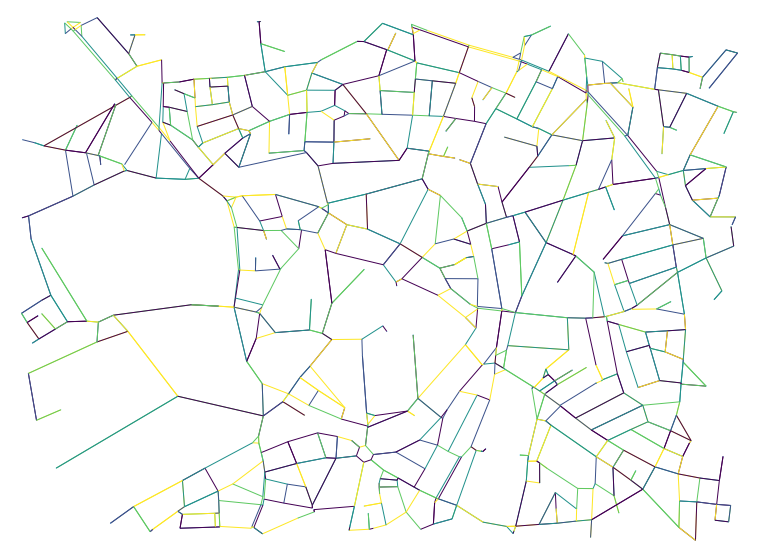

In [212]:
fig, ax = ox.plot_graph(ox.project_graph(graph2), fig_height=10, node_size=1, edge_color=edge_colors, dpi=600)


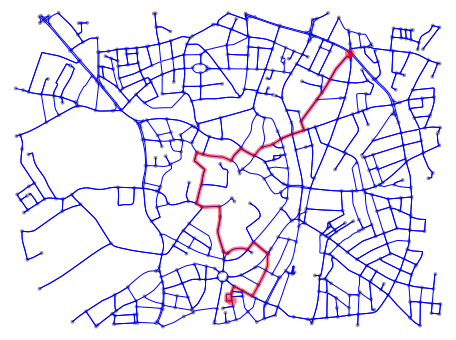

In [213]:
orig = list(graph2)[1]
dest = list(graph2)[-1]
route2 = nx.shortest_path(graph2, orig, dest, weight='co2')

fig, ax = ox.plot_graph_route(graph2, route2, edge_color= 'blue')

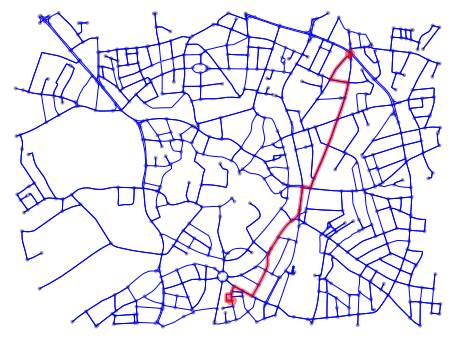

In [182]:
orig = list(graph2)[1]
dest = list(graph2)[-1]
route1 = nx.shortest_path(graph2, orig, dest, weight='time')

fig, ax = ox.plot_graph_route(graph2, route1, edge_color= 'blue')